## Libraries and modules and methods

In [339]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from scipy.stats import pearsonr
from ipywidgets import interact, fixed, IntSlider

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from sklearn.linear_model import Ridge, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

### Import data

In [340]:
raw_data = pd.read_csv("./train.csv").drop('Id', axis=1)

## Data exploration

In [341]:
def categorical_to_int(df):
    return df.transform(lambda x: x.astype('category').cat.codes if x.dtype == 'O' else x)

data_train = categorical_to_int(raw_data)

corr_df = data_train.corr()

In [213]:
#corr_price = corr_df.sort_values(by=['SalePrice'], ascending=False).iloc[:, -1:]
#corr_price.iloc[np.where(np.logical_or(corr_price['SalePrice'] > 0.25, corr_price['SalePrice'] < -0.29))].index

### Plots

In [214]:
#sns.lmplot('a', 'b', data_train)

#f, ax = plt.subplots(figsize=(15, 15))
#sns.heatmap(corr_df, vmax=.8, square=True)

#sns.set()
#sns.pairplot(data_train, size = 2)
#plt.show()

### Feature Engineering

In [215]:
print(data_train.isnull().sum().sort_values(ascending=False).head())
print(np.isfinite(data_train).sum().sort_values().head())

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
SalePrice        0
Foundation       0
dtype: int64
LotFrontage    1201
GarageYrBlt    1379
MasVnrArea     1452
MSSubClass     1460
GarageType     1460
dtype: int64


In [342]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
data_train["LotFrontage"] = data_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Replace na in GarageYrBuilt with 0, since it means there's no garage at all
data_train['GarageYrBlt'] = data_train['GarageYrBlt'].fillna(0)

# Probabily no mansary for na values in MasVnrArea
data_train['MasVnrArea'] = data_train['MasVnrArea'].fillna(0)

In [343]:
X = data_train.drop('SalePrice', axis=1)
y = data_train['SalePrice']

# Models

### Lasso

Text(0,0.5,'smsle')

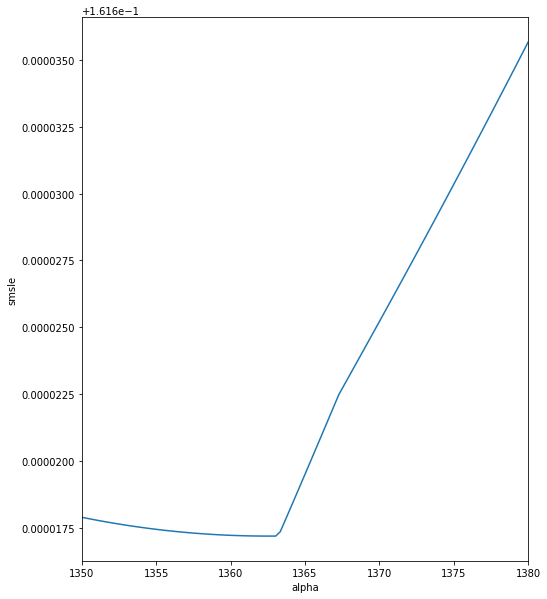

In [245]:
lasso = Lasso(max_iter=5000, random_state=0)

parameter = {'alpha': np.linspace(1350, 1380, 100)}
regressor = GridSearchCV(lasso, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

lasso_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['alpha'])
lasso_scores.plot()
plt.xlabel("alpha")
plt.ylabel("smsle")

# Final Lasso

Text(0.5,1,'Lasso coefficients')

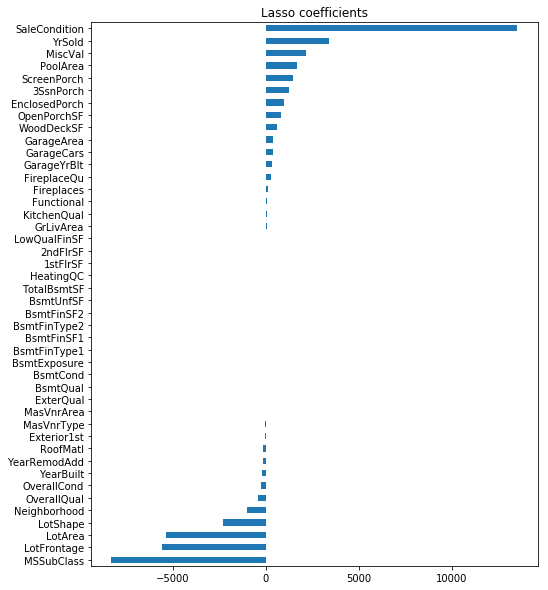

In [344]:
regressor = Lasso(alpha=1360, max_iter=5000, random_state=0).fit(X, y)

feature_lasso = feature_names[np.where(regressor.coef_ != 0)]
X = X[feature_lasso]

non_zero_coef = np.sort(regressor.coef_[np.where(regressor.coef_ != 0)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
pd.Series(non_zero_coef, feature_lasso).plot(kind = "barh")
plt.title("Lasso coefficients")

### Ridge

Text(0,0.5,'smsle')

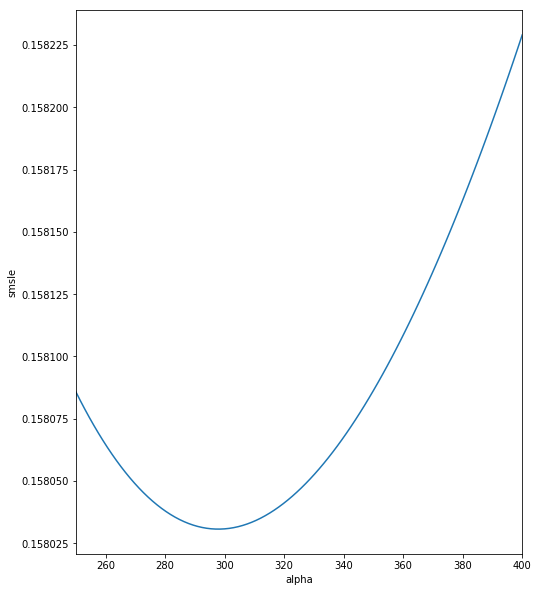

In [179]:
rigde = Ridge(random_state=0)
parameter = {'alpha': np.linspace(250, 400, 100)}
regressor = GridSearchCV(rigde, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

ridge_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['alpha'])
ridge_scores.plot()
plt.xlabel("alpha")
plt.ylabel("smsle")

### ElasticNet

Text(0,0.5,'smsle')

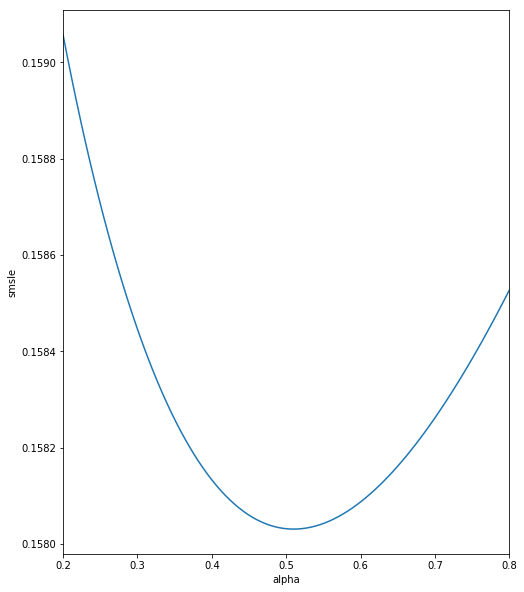

In [184]:
el_net = ElasticNet(random_state=0)

parameter = {'alpha': np.linspace(0.2, 0.8, 100)}
regressor = GridSearchCV(el_net, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

el_net_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['alpha'])
el_net_scores.plot()
plt.xlabel("alpha")
plt.ylabel("smsle")

Text(0,0.5,'smsle')

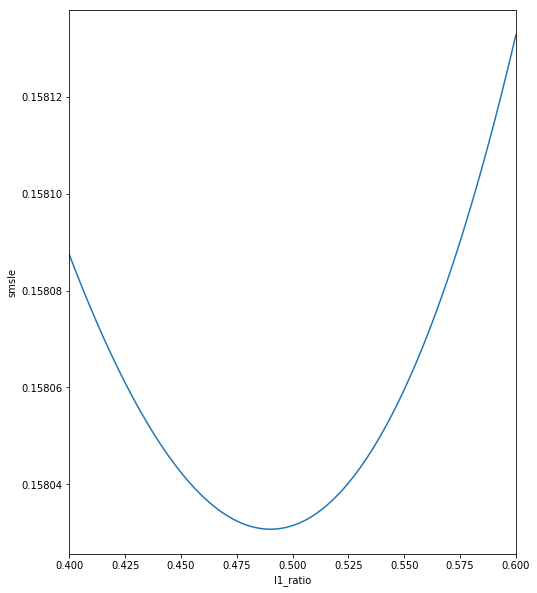

In [199]:
el_net = ElasticNet(alpha=0.5, random_state=0)

parameter = {'l1_ratio': np.linspace(0.40, 0.60, 100)}
regressor = GridSearchCV(el_net, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

el_net_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['l1_ratio'])
el_net_scores.plot()
plt.xlabel("l1_ratio")
plt.ylabel("smsle")

### GradientBoostingRegressor

Text(0,0.5,'smsle')

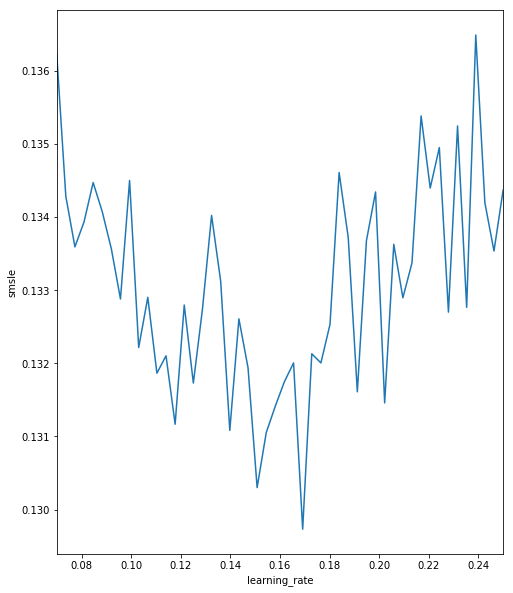

In [345]:
gbr = GradientBoostingRegressor(verbose=0, random_state=0)

parameter = {'learning_rate': np.linspace(0.07, 0.25, 50)}
regressor = GridSearchCV(gbr, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

gbr_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['learning_rate'])
gbr_scores.plot()
plt.xlabel("learning_rate")
plt.ylabel("smsle")

Text(0,0.5,'smsle')

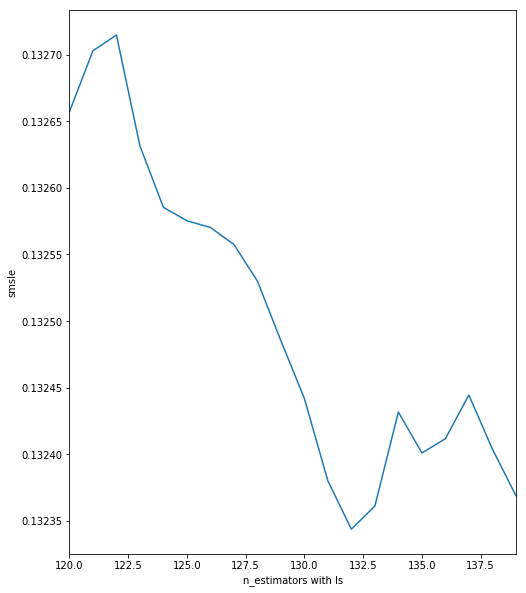

In [346]:
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.15, verbose=0, random_state=0)

parameter = {'n_estimators': np.arange(120, 140)}
regressor = GridSearchCV(gbr, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

gbr_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['n_estimators'])
gbr_scores.plot()
plt.xlabel("n_estimators with ls")
plt.ylabel("smsle")

Text(0,0.5,'smsle')

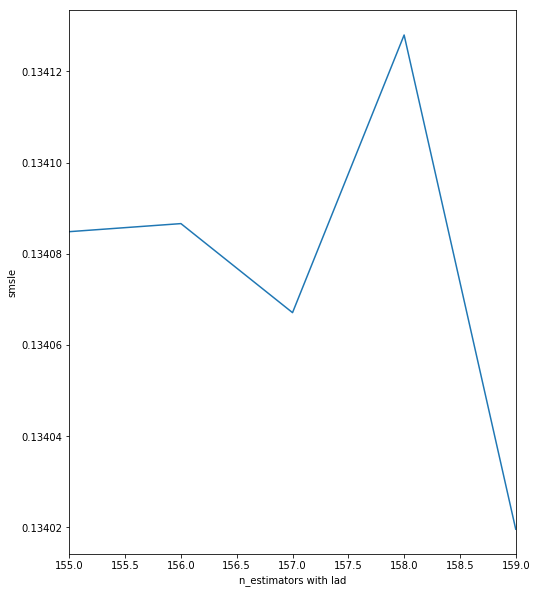

In [347]:
gbr = GradientBoostingRegressor(loss='lad', learning_rate=0.15, verbose=0, random_state=0)

parameter = {'n_estimators': np.arange(155, 160)}
regressor = GridSearchCV(gbr, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

gbr_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['n_estimators'])
gbr_scores.plot()
plt.xlabel("n_estimators with lad")
plt.ylabel("smsle")

Text(0,0.5,'smsle')

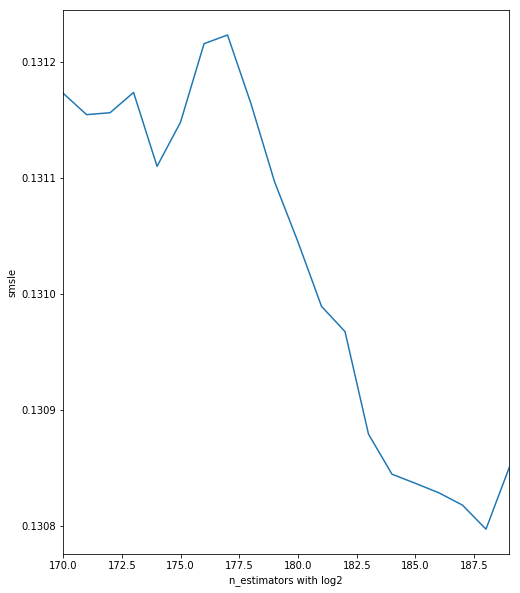

In [348]:
gbr = GradientBoostingRegressor(max_features='log2', learning_rate=0.15, verbose=0, random_state=0)

parameter = {'n_estimators': np.arange(170, 190)}
regressor = GridSearchCV(gbr, parameter, cv=5, n_jobs=2, scoring='neg_mean_squared_log_error', return_train_score=True)
regressor.fit(X, y)

gbr_scores = pd.Series(data=np.sqrt(-regressor.cv_results_['mean_test_score']), index=parameter['n_estimators'])
gbr_scores.plot()
plt.xlabel("n_estimators with log2")
plt.ylabel("smsle")

# Winners!!!

### Read Data

In [349]:
data_test = categorical_to_int(pd.read_csv('test.csv').drop('Id', axis=1))

## Feature Engineering

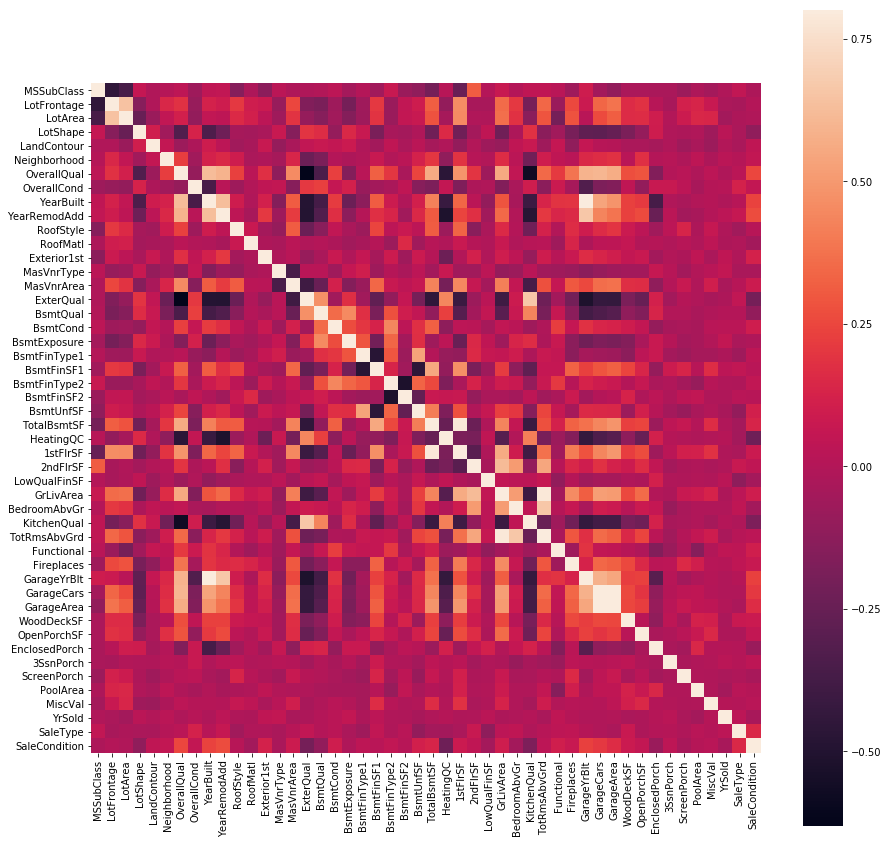

In [109]:
corr_df = data_test[feature_lasso].corr()

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_df, vmax=.8, square=True)

#sns.set()
#sns.pairplot(data_train, size = 2)
#plt.show()

In [290]:
print(data_test[feature_lasso].isnull().sum().sort_values(ascending=False).head(15))
print(np.isfinite(data_test[feature_lasso]).sum().sort_values().head(15))

LotFrontage     227
GarageYrBlt      78
MasVnrArea       15
BsmtUnfSF         1
GarageArea        1
TotalBsmtSF       1
BsmtFinSF1        1
GarageCars        1
BsmtFinSF2        1
YearBuilt         0
OverallCond       0
OverallQual       0
Neighborhood      0
RoofMatl          0
Exterior1st       0
dtype: int64
LotFrontage      1232
GarageYrBlt      1381
MasVnrArea       1444
BsmtFinSF2       1458
BsmtFinSF1       1458
TotalBsmtSF      1458
GarageCars       1458
GarageArea       1458
BsmtUnfSF        1458
OpenPorchSF      1459
EnclosedPorch    1459
3SsnPorch        1459
ScreenPorch      1459
FireplaceQu      1459
Fireplaces       1459
dtype: int64


In [350]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
data_test["LotFrontage"] = data_test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Probabily no mansary for na values in MasVnrArea
# No garage, area 0, 0 cars, year built (?)
# Maybe no basement for NaN
for feature in ('MasVnrArea', 'MasVnrArea', 'GarageArea', 'GarageYrBlt', 'GarageCars', 
                'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2'):
    data_test[feature].fillna(0, inplace=True)


In [292]:
print(not np.any(np.isnan(data_test[feature_lasso])))
print(np.all(np.isfinite(data_test[feature_lasso])))

True
True


In [355]:
X = X[feature_lasso]
X_test = data_test[feature_lasso]

# Final Results :o

In [356]:
gbr = GradientBoostingRegressor(learning_rate=0.12, 
                                n_estimators=165, 
                                loss='lad', max_features='auto', 
                                verbose=0, random_state=0)
gbr.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.12, loss='lad', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=165,
             presort='auto', random_state=0, subsample=1.0, verbose=0,
             warm_start=False)

In [357]:
Id = np.asarray(pd.read_csv('test.csv')['Id'])

pd.DataFrame({'Id': Id, 'SalePrice': gbr.predict(X_test)}).to_csv('GradientBoosting.csv', index=False)